In [1]:
import kagglehub
import numpy as np
import pandas as pd 
import os
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

path = kagglehub.dataset_download("aleemaparakatta/cats-and-dogs-mini-dataset")

print("Path to dataset files:", path)

/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4329.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4223.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4253.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4190.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4354.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4136.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4226.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4214.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4170.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4323.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4262.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4387.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4255.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4203.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4151.jpg
/kaggle/input/cats-and-dogs-mini-dataset/dogs_set/dog.4

Images shape: (1000, 1, 128, 128)
Labels shape: (1000,)
First 5 labels: [0 0 0 0 0]


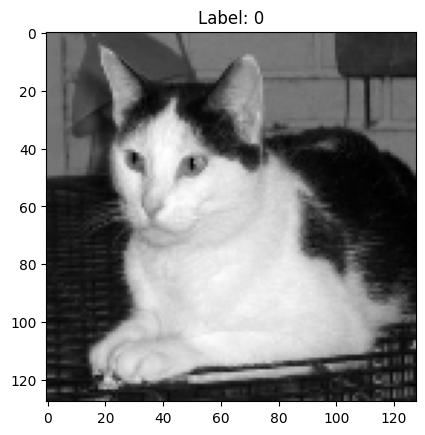

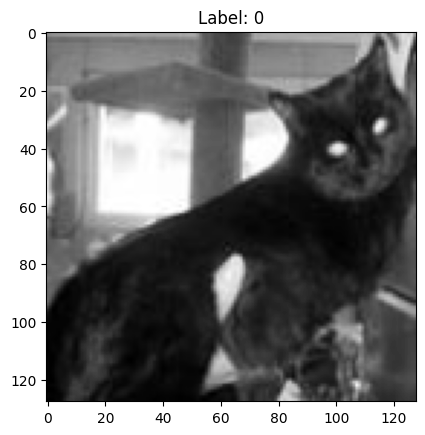

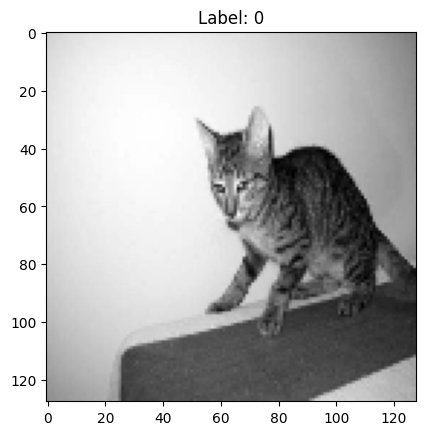

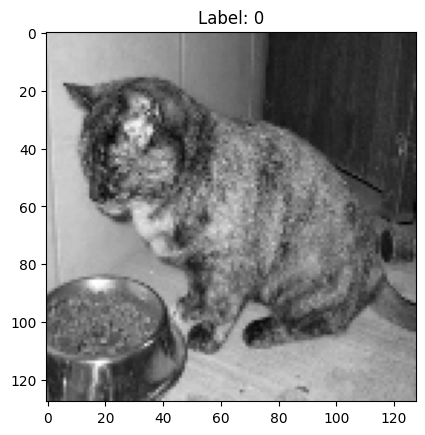

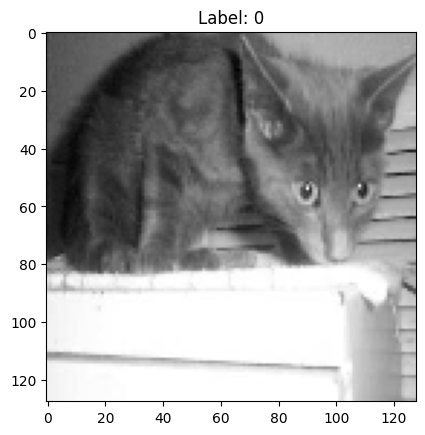

In [2]:
def load_dataset(image_dir):
    images = []
    labels = []
    for category in ["cats_set", "dogs_set"]:
        category_path = os.path.join(image_dir, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image,(128,128))
            images.append(image)
            labels.append(0 if category == "cats_set" else 1)
    return np.array(images), np.array(labels)

image_dir = "/kaggle/input/cats-and-dogs-mini-dataset"
images, labels = load_dataset(image_dir)

images= images/255.0
images= np.expand_dims(images, axis=1)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

print("First 5 labels:", labels[:5])
for i in range(5):
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.show()



In [3]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = torch.Tensor(images)
        self.labels = torch.Tensor(labels).long()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = CustomDataset(train_images,train_labels)
test_dataset = CustomDataset(test_images, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class ANNModel(nn.Module):
    def __init__(self, input_size=128*128, hidden_sizes=[512,256,128,64], dropout_prob=0.5):
        super(ANNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 =nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0],hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1],hidden_sizes[2])
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], 1)

    def forward(self,x):
        x= self.flatten(x)
        x = self.bn1(torch.relu(self.fc1(x)))
        x = self.bn2(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

ann_model = ANNModel()
criterion = nn.BCELoss()
optimizer = optim.RMSprop(ann_model.parameters(), lr=0.001)

def train_model(model,loader,criterion,optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader)}")
        
train_model(ann_model, train_loader, criterion,optimizer)


Epoch [1/20], Loss: 0.7166883444786072
Epoch [2/20], Loss: 0.694075014591217
Epoch [3/20], Loss: 0.6871998882293702
Epoch [4/20], Loss: 0.6692150378227234
Epoch [5/20], Loss: 0.6448626542091369
Epoch [6/20], Loss: 0.6317391085624695
Epoch [7/20], Loss: 0.5954696726799011
Epoch [8/20], Loss: 0.5533299136161804
Epoch [9/20], Loss: 0.5107727015018463
Epoch [10/20], Loss: 0.49051682114601136
Epoch [11/20], Loss: 0.48044936776161196
Epoch [12/20], Loss: 0.42184107899665835
Epoch [13/20], Loss: 0.38535587370395663
Epoch [14/20], Loss: 0.38430770993232727
Epoch [15/20], Loss: 0.30608770430088045
Epoch [16/20], Loss: 0.30367926239967347
Epoch [17/20], Loss: 0.32515515089035035
Epoch [18/20], Loss: 0.2705650591850281
Epoch [19/20], Loss: 0.22481728136539458
Epoch [20/20], Loss: 0.2549510011076927


In [5]:
def evaluate_model(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images,labels in loader:
            outputs = model(images)
            preds = (outputs.squeeze() > 0.5).int()
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
        print(classification_report(all_labels, all_preds))

evaluate_model(ann_model, test_loader)

              precision    recall  f1-score   support

           0       0.48      0.95      0.64        96
           1       0.58      0.07      0.12       104

    accuracy                           0.49       200
   macro avg       0.53      0.51      0.38       200
weighted avg       0.54      0.49      0.37       200



In [6]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32,128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32*32 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

cnn_model = CNNModel()
criterion = nn.BCELoss()
optimizer_cnn = optim.RMSprop(cnn_model.parameters(), lr=0.001)

train_model(cnn_model, train_loader, criterion, optimizer_cnn)
evaluate_model(cnn_model, test_loader)

Epoch [1/20], Loss: 1.0747718811035156
Epoch [2/20], Loss: 0.682049548625946
Epoch [3/20], Loss: 0.664532082080841
Epoch [4/20], Loss: 0.6333139204978943
Epoch [5/20], Loss: 0.5710151994228363
Epoch [6/20], Loss: 0.510073333978653
Epoch [7/20], Loss: 0.42252851247787476
Epoch [8/20], Loss: 0.3366189157962799
Epoch [9/20], Loss: 0.27490563452243805
Epoch [10/20], Loss: 0.18615322798490525
Epoch [11/20], Loss: 0.13516250967979432
Epoch [12/20], Loss: 0.10889456227421761
Epoch [13/20], Loss: 0.06053839512169361
Epoch [14/20], Loss: 0.03175275716930628
Epoch [15/20], Loss: 0.041770293172448875
Epoch [16/20], Loss: 0.017564145401120185
Epoch [17/20], Loss: 0.007901402655988932
Epoch [18/20], Loss: 0.0033978905389085413
Epoch [19/20], Loss: 0.0021691176714375617
Epoch [20/20], Loss: 0.0016439447295852005
              precision    recall  f1-score   support

           0       0.61      0.60      0.61        96
           1       0.64      0.64      0.64       104

    accuracy              

In [7]:
%matplotlib inline

ANN Model Doğruluğu: 49.00%
CNN Model Doğruluğu: 62.50%


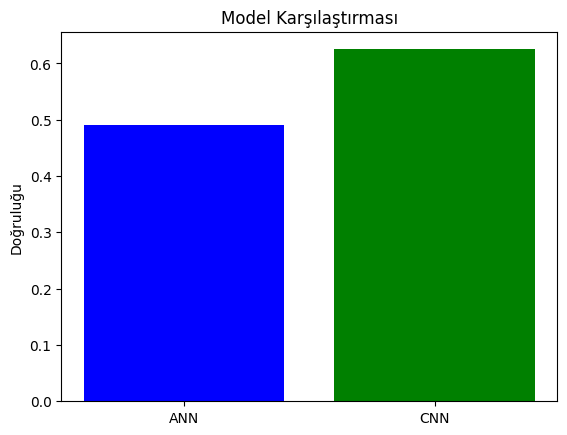

In [8]:
def calculate_accuracy(model, loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            preds = (outputs.squeeze() > 0.5).int()
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

ann_accuracy = calculate_accuracy(ann_model, test_loader)
cnn_accuracy = calculate_accuracy(cnn_model, test_loader)

print(f"ANN Model Doğruluğu: {ann_accuracy *100:.2f}%")
print(f"CNN Model Doğruluğu: {cnn_accuracy *100:.2f}%")

plt.bar(['ANN','CNN'], [ann_accuracy, cnn_accuracy], color=['blue', 'green'])
plt.title('Model Karşılaştırması')
plt.ylabel('Doğruluğu')
plt.show()

--- ANN Modeli Performansı ---
Accuracy (Doğruluk): 0.49
Precision (Kesinlik): 0.58
Recall (Duyarlılık): 0.07
F1-Score: 0.12
-------------------------------
--- CNN Modeli Performansı ---
Accuracy (Doğruluk): 0.62
Precision (Kesinlik): 0.64
Recall (Duyarlılık): 0.64
F1-Score: 0.64
-------------------------------


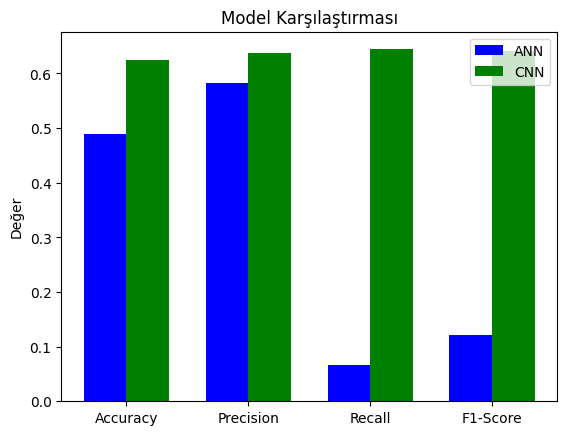

In [9]:
def evaluate_model_detailed(model, loader, model_name):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            preds = (outputs.squeeze() > 0.5).int()
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    print(f"--- {model_name} Performansı ---")
    print(f"Accuracy (Doğruluk): {accuracy:.2f}")
    print(f"Precision (Kesinlik): {precision:.2f}")
    print(f"Recall (Duyarlılık): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print("-------------------------------")
    
    return accuracy, precision, recall, f1

ann_results = evaluate_model_detailed(ann_model, test_loader, "ANN Modeli")

cnn_results = evaluate_model_detailed(cnn_model, test_loader, "CNN Modeli")

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
ann_metrics = list(ann_results)
cnn_metrics = list(cnn_results)

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
bar1 = ax.bar(x - width/2, ann_metrics, width, label='ANN', color='blue')
bar2 = ax.bar(x + width/2, cnn_metrics, width, label='CNN', color='green')

ax.set_ylabel('Değer')
ax.set_title('Model Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()